In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from QG.io import NetCDFWriter

class QG2D_Model(object):
    """
    Dynamical core for a spectral QG
    equation model.
    """
    def __init__(self, N, N2, dt, Lx,Ly,opt = 3, seed=1, 
                 robert_coefficient=0.04):
        """
        Initialize a barotropic model.
        Arguments:
        * vrt : numpy.ndarray[nlat, nlon]
            An initial vorticity field on the desired model grid. The
            grid is assumed to be Gaussian grid, and in general nlon is
            double nlat.
        * truncation : int
            The spectral truncation (triangular). A suggested value is
            nlon // 3.
        * dt : float
            The model time-step in seconds.
        * start_time : datetime.datetime
            A datetime object representing the start time of the model
            run. This doesn't affect computation, it is only used for
            metadata.
        Optional arguments:
        * robert_coefficient : default 0.04
            The coefficient for the Robert time filter.
        """
        # Model grid size:
        self.N=N
        self.N2=N2
        self.x = np.linspace( 0, 2. * np.pi * Lx, N )
        self.y = np.linspace( 0, 2. * np.pi * Ly, N2 ) #domain size
        self.ll = np.fft.fftfreq( N, Ly / float(N2) )
        self.kk = np.fft.rfftfreq( N2, Lx / float(N) )
        
        self.nu = .01 * (self.x[1] - self.x[0]) ** 4 #viscous dissipation
        self.km = 1. / 5.4 #surface friction, corresponds to 25 days in JH
        self.beta = 0.072 #beta in JH
        self.dt = dt #time step
        self.robert_coefficient = robert_coefficient
        self.U = 1. #Maximum upper level wind speed
        #Running EKE spectrum
        self.ta = 100 #How often to calculate spectra
        self.lim = 1 #when to start calculating spectra
        
        
        #Spectral arrays, only need 3 time-steps
        self.psic_1 = np.zeros( ( ( 3, N2, N // 2 + 1 ) ) ).astype( complex )
        self.psic_2 = np.zeros( ( ( 3, N2, N // 2 + 1  ) ) ).astype( complex )
        self.qc_1 = np.zeros( ( ( 3, N2, N // 2 + 1  ) ) ).astype( complex )
        self.qc_2 = np.zeros( ( ( 3, N2, N // 2 + 1  ) ) ).astype( complex )
        self.f0 = 40.
        self.first_step = True
        self.t=0
        self.count=0
        self.opt=3
        
        #Topography -- Gaussian mountain
        self.h_tm = 0.3 #h_max / H_2 (depth of lower layer)
        self.f0 = 40.
        self.xm = max( self.x )
        self.ym = max( self.y )
        self.h_halfx = self.xm / 4. #E-folding length in x-direction
        self.h_halfy = self.ym / 4. #E-folding length in y-direction
        self.h = self.h_tm * np.exp( -( (self.x[np.newaxis, :] - self.xm / 2.)  / self.h_halfx ) ** 2 - ( ( self.y[:, np.newaxis] - self.ym / 2.) / self.h_halfy ) ** 2 )
        #Background PV
        self.Q_1 = np.zeros( ( self.N2, self.N ) )
        self.Q_1[:, :] = (self.beta + self.U / 2.) * self.y[:, np.newaxis]
        self.Q_2 = (self.beta - self.U / 2.) * self.y[:, np.newaxis] + self.f0 * self.h

        self.Q_1c = np.fft.rfft2( self.Q_1)
        self.Q_2c = np.fft.rfft2( self.Q_2)
        
        
    def ptq(self):
        """Calculate PV"""
        self.qc_1[0] = -(self.ll[:, np.newaxis] ** 2 + self.kk[np.newaxis, :] ** 2 ) * self.psic_1[0] - (self.psic_1[0] - self.psic_2[0]) / 2. # -(k^2 + l^2) * psi_1 -0.5*(psi_1-psi_2)
        self.qc_2[0] = -(self.ll[:, np.newaxis] ** 2 + self.kk[np.newaxis, :] ** 2 ) * self.psic_2[0] + (self.psic_1[0] - self.psic_2[0]) / 2. # -(k^2 + l^2) * psi_2 +0.5*(psi_1-psi_2)
        self.qc_1[1] = -(self.ll[:, np.newaxis] ** 2 + self.kk[np.newaxis, :] ** 2 ) * self.psic_1[1] - (self.psic_1[1] - self.psic_2[1]) / 2. # -(k^2 + l^2) * psi_1 -0.5*(psi_1-psi_2)
        self.qc_2[1] = -(self.ll[:, np.newaxis] ** 2 + self.kk[np.newaxis, :] ** 2 ) * self.psic_2[1] + (self.psic_1[1] - self.psic_2[1]) / 2. # -(k^2 + l^2) * psi_2 +0.5*(psi_1-psi_2)
    
    def qtp(self):
        """Invert PV CHECK THIS"""
        psi_bt = -(self.qc_1[2] + self.qc_2[2]) / (self.ll[:, np.newaxis] ** 2 + self.kk[np.newaxis, :] ** 2) / 2.  # (psi_1 + psi_2)/2
        psi_bc = -(self.qc_1[2] - self.qc_2[2]) / (self.ll[:, np.newaxis] ** 2 + self.kk[np.newaxis, :] ** 2 + 1. ) / 2.  # (psi_1 - psi_2)/2
        psi_bt[0, 0] = 0.
        self.psic_1[1] = psi_bt + psi_bc
        self.psic_2[1] = psi_bt - psi_bc
        
        psi_bt = -(self.qc_1[1] + self.qc_2[1]) / (self.ll[:, np.newaxis] ** 2 + self.kk[np.newaxis, :] ** 2) / 2.  # (psi_1 + psi_2)/2
        psi_bc = -(self.qc_1[1] - self.qc_2[1]) / (self.ll[:, np.newaxis] ** 2 + self.kk[np.newaxis, :] ** 2 + 1. ) / 2.  # (psi_1 - psi_2)/2
        psi_bt[0, 0] = 0.
        self.psic_1[0] = psi_bt + psi_bc
        self.psic_2[0] = psi_bt - psi_bc
        
    def random_init(self):
        
        print('starting from scratch')
        self.psic_1[0] = [ [ random.random()  * 10. ** -3. for i in range(self.N // 2 + 1) ] for j in range(self.N2) ]
        self.psic_2[0] = [ [ random.random()  * 10. ** -3. for i in range(self.N // 2 + 1) ] for j in range(self.N2) ]
    
    
        self.psic_1[0, 0, 0] = 0.
        self.psic_2[0, 0, 0] = 0.
    
        #Transfer values:
        self.psic_1[ 1 , : , : ] = self.psic_1[ 0 , : , : ]
        self.psic_2[ 1 , : , : ] = self.psic_2[ 0 , : , : ]
    

        #Calculate initial PV
        self.ptq()
        
        
    def integrate(self):
        """Step the model forward in time by one time-step."""
        [rhs1,rhs2] = calcrhs(self.qc_1, self.qc_2, self.psic_1, self.psic_2, 
                              self.N,self.N2,self.ll,self.kk,self.Q_2c,self.U,self.beta,self.km,self.opt)
        if self.first_step:
            #Forward step
            self.qc_1[2, :] = fs(self.qc_1[1, :, :], rhs1[:], self.dt,self.kk,self.ll,self.nu)
            self.qc_2[2, :] = fs(self.qc_2[1, :, :], rhs2[:], self.dt,self.kk,self.ll,self.nu)
            self.first_step = False
        
        else:
            self.qc_1[2, :, :] = lf(self.qc_1[0, :, :], rhs1[:], self.dt,self.ll,self.kk,self.nu)
            self.qc_2[2, :, :] = lf(self.qc_2[0, :, :], rhs2[:], self.dt,self.ll,self.kk,self.nu)
        
            self.qc_1[1, :] = filt( self.qc_1[1, :], self.qc_1[0, :], self.qc_1[2, :],self.robert_coefficient)
            self.qc_2[1, :] = filt( self.qc_2[1, :], self.qc_2[0, :], self.qc_2[2, :],self.robert_coefficient)
    
            #Invert:
        self.qtp()
        
        #Transfer values:
        self.qc_1[0, :, :] = self.qc_1[1, :, :]
        self.qc_2[0, :, :] = self.qc_2[1, :, :]
        self.qc_1[1, :, :] = self.qc_1[2, :, :]
        self.qc_2[1, :, :] = self.qc_2[2, :, :]
        self.t += self.dt
        self.count += 1
        
    def run_with_snapshots(self, run_time, snapshot_start=0,
                           snapshot_interval=None):
        """
        A generator that runs the model for a specific amount of time,
        yielding at specified intervals.
        Argument:
        * run_time : float
            The amount of time to run for in seconds.
        Keyword arguments:
        * snapshot_start : default 0
            Don't yield until at least this amount of time has passed,
            measured in seconds.
        * snapshot_interval : float
            The interval between snapshots in seconds.
        """
        snapshot_interval = snapshot_interval or self.dt
        if snapshot_interval < self.dt:
            snapshot_interval = self.dt
        target_steps = int(math.ceil((self.t + run_time) / self.dt))
        print(target_steps)
        step_interval = int(math.ceil(snapshot_interval / self.dt))
        start_time = self.t
        n = 0
        while n <= target_steps:
            self.integrate()
            n += 1
            if self.t > snapshot_start and n % step_interval == 0:
                yield self.t

        

### other utilities

In [2]:

#######################################################
#  Spectral functions
#######################################################
#  Spectral functions
def ptq(ps1,ps2,ll,kk):
    """Calculate PV"""
    q1 = -(ll[:, np.newaxis] ** 2 + kk[np.newaxis, :] ** 2 ) * ps1 - (ps1 - ps2) / 2. # -(k^2 + l^2) * psi_1 -0.5*(psi_1-psi_2)
    q2 = -(ll[:, np.newaxis] ** 2 + kk[np.newaxis, :] ** 2 ) * ps2 + (ps1 - ps2) / 2. # -(k^2 + l^2) * psi_2 +0.5*(psi_1-psi_2)
    return q1, q2

def qtp(q1_s,q2_s,ll,kk):
    """Invert PV"""
    psi_bt = -(q1_s + q2_s) / (ll[:, np.newaxis] ** 2 + kk[np.newaxis, :] ** 2) / 2.  # (psi_1 + psi_2)/2
    psi_bc = -(q1_s - q2_s) / (ll[:, np.newaxis] ** 2 + kk[np.newaxis, :] ** 2 + 1. ) / 2.  # (psi_1 - psi_2)/2
    psi_bt[0, 0] = 0.
    psi1 = psi_bt + psi_bc
    psi2 = psi_bt - psi_bc

    return psi1, psi2

#######################################################
#######################################################
#  Time-stepping functions
def calc_nl(psi, qc ):
    """"Calculate non-linear terms, with Orszag 3/2 de-aliasing"""
    N2, N = np.shape( psi )
    ex = N *  3 / 2 - 1
    ex2 = N2 * 3 / 2 - 1
    temp1 = np.zeros( ( int(ex2), int(ex )) ).astype( complex )
    temp2 = np.zeros( ( int(ex2), int(ex) ) ).astype( complex )
    temp4 = np.zeros( ( int(N2), int(N) ) ).astype( complex )	#Final array

    #Pad values:
    temp1[:N2//2, :N] = psi[:N2//2, :N]
    temp1[int(ex2-N2//2):, :N] = psi[N2//2:, :N]

    temp2[:N2//2, :N] = qc[:N2//2, :N]
    temp2[int(ex2-N2//2):, :N] = qc[N2//2:, :N]

    #Fourier transform product, normalize, and filter:
    temp3 = np.fft.rfft2( np.fft.irfft2( temp1 ) * np.fft.irfft2( temp2 ) ) * 9. / 8.
    temp4[:N2//2, :N] = temp3[:N2//2, :N]
    temp4[N2//2:, :N] = temp3[int(ex2-N2//2):, :N]

    return temp4

def nlterm(kk, ll, psi, qc):
    """"Calculate Jacobian"""
    dpsi_dx = 1.j * kk[np.newaxis, :] * psi 
    dpsi_dy = 1.j * ll[:, np.newaxis] * psi 

    dq_dx = 1.j * kk[np.newaxis, :] * qc
    dq_dy = 1.j * ll[:, np.newaxis] * qc 

    return  calc_nl( dpsi_dx, dq_dy ) - calc_nl( dpsi_dy, dq_dx )


def fs(ovar, rhs, det,kk,ll,nu):
    """Forward Step: q^t-1 / ( 1 + 2. dt * nu * (k^4 + l^4 ) ) + RHS"""
    mult = det / ( 1. + det * nu * (kk[np.newaxis, :]** 4  + ll[:, np.newaxis]** 4 ) )

    return mult * (ovar / det + rhs)

def lf(oovar, rhs, det,ll,kk,nu):
    """Leap frog timestepping: q^t-2 / ( 1 + 2. * dt * nu * (k^4 + l^4 ) ) + RHS"""
    mult = 2. * det / ( 1. + 2. * det * nu * (kk[np.newaxis, :] ** 4 + ll[:, np.newaxis] ** 4) )
    return mult * (oovar / det / 2. + rhs)

def filt(var, ovar, nvar,g):
    """Leapfrog filtering"""
    return var + g * (ovar - 2. * var + nvar )
########################################################
#new functionality 
########################################################
def calcrhs(qc1, qc2, psi1, psi2, N, N2, ll, kk,Q_2c,U,beta,km,opt):
    
    forc1 = np.zeros( ( N2, N // 2 + 1 ) ).astype(complex)
    forc2 = np.zeros( ( N2, N // 2 + 1 ) ).astype(complex)
    nl1 = np.zeros( ( N2, N // 2 + 1 ) ).astype(complex)
    nl2 = np.zeros( ( N2, N // 2 + 1 ) ).astype(complex)
    

    
    if opt > 1:
        #NL terms -J(psi, qc) , in lower layer add Q_2c because topography has x dimension
        nl1[:, :] = -nlterm( kk, ll, psi1[1, :, :], qc1[1, :, :]) 
        nl2[:, :] = -nlterm( kk, ll, psi2[1, :, :], qc2[1, :, :] + Q_2c)

    if opt != 2:
        #linear terms 
        forc1[:] = -1.j * kk[np.newaxis, :] * (U * qc1[1, :, :] + (beta + U / 2) * psi1[1, :, :])
        forc2[:] = km * ( kk[np.newaxis, :]** 2  + ll[:, np.newaxis]** 2 )  * psi2[1, :, :]

    rhs1 = nl1[:] + forc1[:]
    rhs2 = nl2[:] + forc2[:]
    
    return rhs1,rhs2





def calcrhs_SGS(self, qc1, qc2, psi1, psi2, ll,kk, N, N2, maskll,maskkk):
    
    forc1 = np.zeros( ( N2, N // 2 + 1 ) ).astype(complex)
    forc2 = np.zeros( ( N2, N // 2 + 1 ) ).astype(complex)
    nl1 = np.zeros( ( N2, N // 2 + 1 ) ).astype(complex)
    nl2 = np.zeros( ( N2, N // 2 + 1 ) ).astype(complex)
        
    psi1 = psi1[:,maskll,:]
    psi1 = psi1[:,:,maskkk]
    
    psi2 = psi2[:,maskll,:]
    psi2 = psi2[:,:,maskkk]
    
    qc1 = qc1[:,maskll,:]
    qc1 = qc1[:,:,maskkk]
    
    qc2 = qc2[:,maskll,:]
    qc2 = qc2[:,:,maskkk]
    

    
    if opt > 1:
        #NL terms -J(psi, qc) , in lower layer add Q_2c because topography has x dimension
        nl1[:, :] = -nlterm( kk, ll, psi1[1, :, :], qc1[1, :, :]) 
        nl2[:, :] = -nlterm( kk, ll, psi2[1, :, :], qc2[1, :, :] + Q_2cs)

    if opt != 2:
        #linear terms 
        forc1[:] = -1.j * kk[np.newaxis, :] * (U * qc1[1, :, :] + (beta + U / 2) * psi1[1, :, :])
        forc2[:] = km * ( kk[np.newaxis, :]** 2  + ll[:, np.newaxis]** 2 )  * psi2[1, :, :]

    rhs1 = nl1[:] + forc1[:]
    rhs2 = nl2[:] + forc2[:]
    
    return rhs1,rhs2
    

In [193]:
mod1 = QG2D_Model(64,64,0.005,10,10)
print('Saving output at time: {}'.format(mod1.t))
mod1.integrate()
saver = NetCDFWriter(mod1, 'New_Initiialize.nc')

for ii in range(0,200):
    mod1.integrate()
    saver.save()

saver.close()

Saving output at time: 0


/Users/will/anaconda2/envs/Dawson/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide
/Users/will/anaconda2/envs/Dawson/lib/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide


In [3]:
mod1 = QG2D_Model(64,64,0.005,10,10)

hour = 10
run_time = 5 * hour
output_interval = 1 * hour

# The run_with_snapshots method is an iterator that yields the
# current model time at the given interval. This means we can
# loop over the iterator saving the current model state.
for t in mod1.run_with_snapshots(run_time, snapshot_interval=output_interval):
    print('Saving output at time: {}'.format(mod1.t))
    saver = NetCDFWriter(mod1, 'model4.nc')
    saver.save()
    saver.close()
    

10000


/Users/will/anaconda2/envs/Dawson/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide
/Users/will/anaconda2/envs/Dawson/lib/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide


KeyboardInterrupt: 

starting from scratch


/Users/will/anaconda2/envs/Dawson/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/will/anaconda2/envs/Dawson/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/will/anaconda2/envs/Dawson/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
/Users/will/anaconda2/envs/Dawson/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide


2000


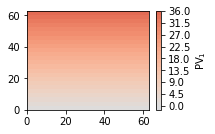

4000


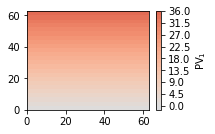

6000


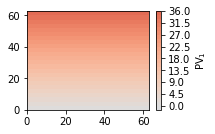

8000


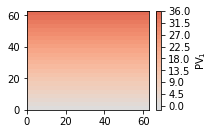

10000


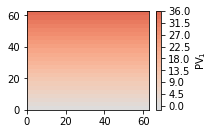

12000


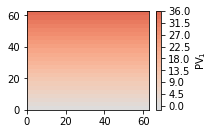

14000


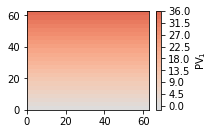

16000


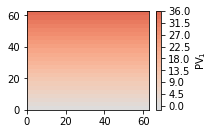

18000


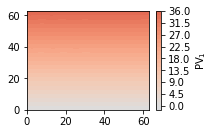

20000


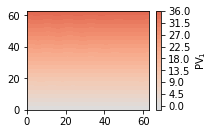

22000


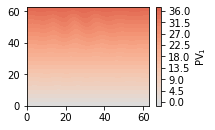

24000


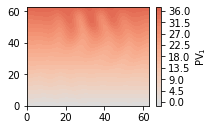

26000


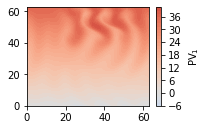

28000


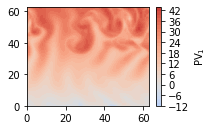

30000


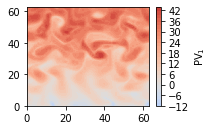

32000


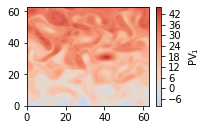

34000


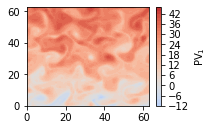

36000


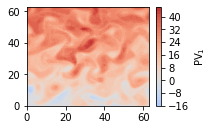

38000


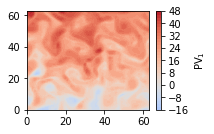

40000


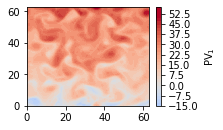

42000


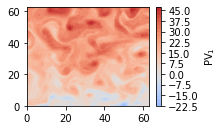

44000


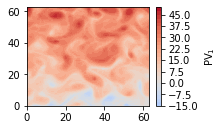

46000


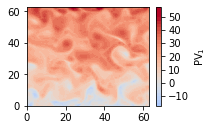

48000


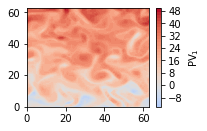

In [8]:
mod1 = QG2D_Model(64,64,0.005,10,10)
mod1.ptq()
mod1.qc_1
mod1.random_init()
mod1.qc_1
mod1.integrate()

for ii in range(1,50000):
    if ii % 2000 ==0:
        print(ii)
        ax = plt.subplot(2, 2, 3)
        plt.contourf( mod1.x, mod1.y, mod1.Q_1 + np.fft.irfft2( mod1.qc_1[1] ),30,cmap = plt.cm.coolwarm, vmin=-50,vmax=50)
        cs = plt.colorbar()
        cs.set_label("PV$_1$")
        plt.show()
    mod1.integrate()




In [32]:
mod1.x.shape[0]

64

In [34]:
import os
os.getcwd()

'/Volumes/HotSlop/QG_tot'